# CheXpert : A Large Chest X-Ray Dataset and Competition

This competition launched by the Stanford ML group aims at finding a prediction model which could perform as well as radiologist to find different pathologies thanks to chest X-Ray. The Dataset available to train our model is composed of 223,414 chest radiographs of 65,240 patients.

<img src="view1_frontal.jpg" title="X-Ray image of the dataset" width = 320/>

The website of the competition:
https://stanfordmlgroup.github.io/competitions/chexpert/

[Publication](https://arxiv.org/pdf/1901.07031.pdf) : Irvin, Jeremy, et al. "CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison." arXiv preprint arXiv:1901.07031 (2019).

Our goal is first to reproduce main results obtained in the related paper, published in January 2019.

In [1]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score

use_gpu = torch.cuda.is_available()

In [2]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
pathFileTrain = '../CheXpert-v1.0-small/train.csv'
pathFileValid = '../CheXpert-v1.0-small/valid.csv'

# Neural network parameters:
nnIsTrained = False                 #pre-trained using ImageNet
nnClassCount = 14                   #dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 64
trMaxEpoch = 1

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
       'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

## 1. Create a Dataset

In this first part, we create a loader able to load the data thanks to the csv files of the dataset.
This loader first load labels and paths to the different images.

It includes a pre-processing of labels to deal with uncertainty labels.
Indeed, four different labels exist:
-  **Blanks ('')**: the existence of the pathology is unknown
-  **Ones (1)**: the pathology is detected thanks to the image
-  **Zeros (0)**: the pathology can't be detected thanks to the image
-  **Uncertain (-1)**: the pathology may be detected.

In order to deal with uncertainty labels, different policies can be applied. The easiest ones consists in changing those **Uncertain** labels to *Blanks*, *Ones* or *Zeros*. This process is done thanks to the following class.

**PROBLEME BLANKS AVEC DATALOADER PYTORCH**

In [3]:
class CheXpertDataSet(Dataset):
    def __init__(self, image_list_file, transform=None, policy="ones", nmax = None):
        """
        Args:
            image_list_file: path to the file containing images
                with corresponding labels.
            transform: optional transform to be applied on a sample.
            Upolicy: name the policy with regard to the uncertain labels
        """
        image_names = []
        labels = []

        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                if nmax!=None and k>nmax:
                    break
                image_name= line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_names.append('../' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item

        Returns:
            image and its labels
        """
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

## 2. Create DataLoaders

First we define a transform model to resize all images and normalize them.

In [4]:
#TRANSFORM DATA

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
#transformList.append(transforms.Resize(imgtransResize)) #a regarder
transformList.append(transforms.RandomResizedCrop(imgtransCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence=transforms.Compose(transformList)

Then we build train, validation and test data loaders. 

In [5]:
#LOAD DATASET

dataset = CheXpertDataSet(pathFileTrain ,transformSequence, policy=1)
datasetTest, datasetTrain = random_split(dataset, [500, len(dataset) - 500])
datasetValid = CheXpertDataSet(pathFileValid, transformSequence)            
#Problèmes de l'overlapping de patients et du transform identique ?

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=24, pin_memory=True)
dataLoaderVal = DataLoader(dataset=datasetValid, batch_size=trBatchSize, shuffle=False, num_workers=24, pin_memory=True)
dataLoaderTest = DataLoader(dataset=datasetTest, num_workers=24, pin_memory=True)

## 3. Create train and test models

First we define a transform model to resize all images and normalize them.

In [6]:
class CheXpertTrainer():

    #---- nnClassCount - number of output classes 
    #---- trMaxEpoch - number of epochs
    #---- launchTimestamp - date/time, used to assign unique name for the checkpoint file
    #---- checkpoint - if not None loads the model and continues training
    
    def train (model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, launchTimestamp, checkpoint):
        
        
        #SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
                
        #SETTINGS: LOSS
        loss = torch.nn.BCELoss(size_average = True)
        
        #LOAD CHECKPOINT 
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])

        
        #TRAIN THE NETWORK
        
        lossMIN = 100000
        
        for epochID in range(0, trMaxEpoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
            
            batchs, losst, losse = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            lossVal = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)


            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            
            if lossVal < lossMIN:
                lossMIN = lossVal    
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'm-epoch'+str(epochID)+'-' + launchTimestamp + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
        
        return batchs, losst, losse        
    #-------------------------------------------------------------------------------- 
       
    def epochTrain(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        batch = []
        losstrain = []
        losseval = []
        
        model.train()

        for batchID, (varInput, target) in enumerate(dataLoaderTrain):
            
            varTarget = target.cuda(non_blocking = True) 
            varInput.requires_grad = True
            varOutput = model(varInput)
        
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            l = lossvalue.item()
            losstrain.append(l)
            
            if batchID%35==0:
                print(batchID//35, "% batches computed")
                #Fill three arrays to see the evolution of the loss


                batch.append(batchID)
                
                le = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss).item()
                losseval.append(le)
                
                print(batchID)
                print(l)
                print(le)
                
        return batch, losstrain, losseval
    
    #-------------------------------------------------------------------------------- 
    
    def epochVal(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        model.eval()
        
        lossVal = 0
        lossValNorm = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)
                
                losstensor = loss(varOutput, target)
                lossVal += losstensor
                lossValNorm += 1
                
        outLoss = lossVal / lossValNorm
        return outLoss
    
    
    #--------------------------------------------------------------------------------     
     
    #---- Computes area under ROC curve 
    #---- dataGT - ground truth data
    #---- dataPRED - predicted data
    #---- classCount - number of classes
    
    def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        print(datanpGT)
        print(datanpPRED)
        
        for i in range(classCount):
            outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            
        return outAUROC
        
        
    #-------------------------------------------------------------------------------- 
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint):   
        
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):
                
                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                print(out)

                outPRED = torch.cat((outPRED, out), 0)
                print(outPRED)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        
        print ('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print (class_names[i], ' ', aurocIndividual[i])

In [8]:
class DenseNet121(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [9]:
# initialize and load the model
if use_gpu:
    model = DenseNet121(nnClassCount).cuda()
    model = torch.nn.DataParallel(model).cuda()
else:
    model = DenseNet121(nnClassCount)
    model = torch.nn.DataParallel(model)

/home/gaetandi/miniconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

#last model saved : "m-epoch0-07032019-213933.pth.tar"
batch, losst, losse = CheXpertTrainer.train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, timestampLaunch, checkpoint = "model1.pth.tar")
print("Model trained")

In [ ]:
losstn = []
for i in range(0, len(losst), 35):
    losstn.append(np.mean(losst[i:i+35])

In [9]:
losstn=[0.6728807091712952, 0.43882980942726135, 0.448734313249588, 0.3944702744483948, 0.4168243706226349, 0.4108811020851135, 0.4063291847705841, 0.41022342443466187, 0.3835395276546478, 0.3770408034324646, 0.43638280034065247, 0.3838731348514557, 0.41709738969802856, 0.3788347840309143, 0.4156818389892578, 0.40620699524879456, 0.39896196126937866, 0.41358619928359985, 0.3962070047855377, 0.3510574698448181, 0.4177820384502411, 0.38106709718704224, 0.39271387457847595, 0.39069268107414246, 0.4015863239765167, 0.4040599763393402, 0.36674314737319946, 0.39783015847206116, 0.39709019660949707, 0.39561790227890015, 0.3752536475658417, 0.3812060058116913, 0.3846367299556732, 0.37263208627700806, 0.39953988790512085, 0.38198143243789673, 0.38135018944740295, 0.3660784065723419, 0.3849000930786133, 0.39580315351486206, 0.37385669350624084, 0.4011920392513275, 0.38841670751571655, 0.39842209219932556, 0.37201929092407227, 0.3926997184753418, 0.3799830377101898, 0.34905099868774414, 0.39441245794296265, 0.39433833956718445, 0.4047241806983948, 0.40487736463546753, 0.395306259393692, 0.35388389229774475, 0.4141821265220642, 0.3878190815448761, 0.40146785974502563, 0.3607812225818634, 0.42003124952316284, 0.36781835556030273, 0.4019395709037781, 0.4063832759857178, 0.40765056014060974, 0.35358932614326477, 0.3856630325317383, 0.3571811318397522, 0.40113481879234314, 0.3867679536342621, 0.381091445684433, 0.3658832609653473, 0.3639684021472931, 0.3864218294620514, 0.40048930048942566, 0.41680869460105896, 0.32693132758140564, 0.38254183530807495, 0.3829517364501953, 0.40478089451789856, 0.37888893485069275, 0.387321799993515, 0.3875291049480438, 0.3538939356803894, 0.3909098505973816, 0.3872263729572296, 0.38510894775390625, 0.36245647072792053, 0.3746325671672821, 0.38296589255332947, 0.3871270716190338, 0.3788798153400421, 0.38520655035972595, 0.3798528015613556, 0.3944593071937561, 0.38830438256263733, 0.3603636920452118, 0.38289493322372437, 0.3635413944721222, 0.38682428002357483, 0.40535497665405273, 0.3861527740955353]
losse=[0.666441023349762, 0.443545401096344, 0.4402904808521271, 0.41923344135284424, 0.40610837936401367, 0.4354133903980255, 0.4100918173789978, 0.40635162591934204, 0.4041239321231842, 0.40100377798080444, 0.4028412401676178, 0.41881391406059265, 0.39728015661239624, 0.4003562331199646, 0.4011349081993103, 0.389141321182251, 0.4138961732387543, 0.40326550602912903, 0.40392830967903137, 0.38794854283332825, 0.40368518233299255, 0.41165873408317566, 0.38464340567588806, 0.3873163163661957, 0.41243594884872437, 0.3923010528087616, 0.40889692306518555, 0.39840763807296753, 0.3808088004589081, 0.40207257866859436, 0.4016839265823364, 0.3945044279098511, 0.3993243873119354, 0.38558343052864075, 0.3936128318309784, 0.38058415055274963, 0.3843187093734741, 0.3853977918624878, 0.37252265214920044, 0.3892264664173126, 0.377424031496048, 0.3721745014190674, 0.38715660572052, 0.3823164403438568, 0.3870171308517456, 0.3748817443847656, 0.4068020284175873, 0.3829105496406555, 0.37821173667907715, 0.38521310687065125, 0.37045013904571533, 0.37721696496009827, 0.37799766659736633, 0.38296109437942505, 0.3845213055610657, 0.38360336422920227, 0.389581561088562, 0.3840208649635315, 0.371692419052124, 0.3676907420158386, 0.3929951786994934, 0.37962183356285095, 0.3837434649467468, 0.3645118176937103, 0.3752654194831848, 0.37253111600875854, 0.40444105863571167, 0.39687687158584595, 0.38618138432502747, 0.38364624977111816, 0.38598179817199707, 0.36292433738708496, 0.39321988821029663, 0.377773642539978, 0.3815804123878479, 0.3753972351551056, 0.36458322405815125, 0.3598563075065613, 0.3723699450492859, 0.37792229652404785, 0.3774971663951874, 0.37759989500045776, 0.3747633695602417, 0.3724086284637451, 0.37157726287841797, 0.3746485710144043, 0.3860815763473511, 0.37445831298828125, 0.3731172978878021, 0.37790602445602417, 0.3680556118488312, 0.3752572536468506, 0.38026267290115356, 0.3717893660068512, 0.38101106882095337, 0.39427292346954346, 0.3680296540260315, 0.3675823509693146, 0.37638282775878906, 0.3839713931083679]
batch = [i*35 for i in range(len(losstn))]

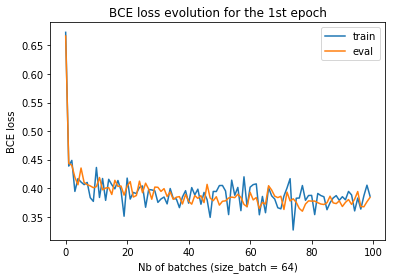

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(batch, losstn, label = "train")
plt.plot(batch, losse, label = "eval")
plt.xlabel("Nb of batches (size_batch = 64)")
plt.ylabel("BCE loss")
plt.title("BCE loss evolution for the 1st epoch")
plt.legend()
plt.show()

plt.savefig("chart.png")

## 6. Test and ROC Curves

In [10]:
CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, checkpoint = "model1.pth.tar")

tensor([[0.0010, 0.1068, 0.3360, 0.6987, 0.0412, 0.2378, 0.4348, 0.1021, 0.5558,
         0.0440, 0.9719, 0.0139, 0.0142, 0.3197]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360, 0.6987, 0.0412, 0.2378, 0.4348, 0.1021, 0.5558,
         0.0440, 0.9719, 0.0139, 0.0142, 0.3197]], device='cuda:0')
tensor([[0.0097, 0.0953, 0.1313, 0.6669, 0.0881, 0.4419, 0.3038, 0.2469, 0.2432,
         0.0780, 0.7633, 0.0370, 0.0326, 0.5039]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360, 0.6987, 0.0412, 0.2378, 0.4348, 0.1021, 0.5558,
         0.0440, 0.9719, 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313, 0.6669, 0.0881, 0.4419, 0.3038, 0.2469, 0.2432,
         0.0780, 0.7633, 0.0370, 0.0326, 0.5039]], device='cuda:0')
tensor([[0.0038, 0.1264, 0.3808, 0.6322, 0.0141, 0.4408, 0.3117, 0.0651, 0.4780,
         0.0184, 0.7287, 0.0043, 0.0171, 0.7574]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360, 0.6987, 0.0412, 0.2378, 0.4348, 0.1021, 0.5558,
         0.0440, 0.9719, 0.0139, 0.0142, 0.

tensor([[0.0863, 0.1099, 0.0526, 0.4212, 0.0407, 0.1384, 0.1304, 0.0778, 0.2559,
         0.0613, 0.2574, 0.0189, 0.0571, 0.6580]], device='cuda:0')
tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03

tensor([[0.0042, 0.0999, 0.2428, 0.6615, 0.0384, 0.4269, 0.2766, 0.1508, 0.3449,
         0.0780, 0.6501, 0.0111, 0.0265, 0.4738]], device='cuda:0')
tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03

tensor([[0.5985, 0.0952, 0.0057, 0.1305, 0.0728, 0.0082, 0.0347, 0.0245, 0.0762,
         0.1103, 0.0791, 0.0195, 0.0727, 0.7660]], device='cuda:0')
tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03

tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03, 6.9156e-01,
         2.8063e-01, 7.4511e-02, 3.6749e-01, 2.0442e-02, 8.8126e-01, 1.6455e-03,
         8.6766e-03, 8.9874e-01],
        [6.3796e-04,

tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03, 6.9156e-01,
         2.8063e-01, 7.4511e-02, 3.6749e-01, 2.0442e-02, 8.8126e-01, 1.6455e-03,
         8.6766e-03, 8.9874e-01],
        [6.3796e-04,

tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03, 6.9156e-01,
         2.8063e-01, 7.4511e-02, 3.6749e-01, 2.0442e-02, 8.8126e-01, 1.6455e-03,
         8.6766e-03, 8.9874e-01],
        [6.3796e-04,

tensor([[0.0686, 0.1172, 0.1073, 0.4349, 0.0258, 0.2061, 0.2117, 0.0945, 0.4430,
         0.1075, 0.2736, 0.0107, 0.0484, 0.3418]], device='cuda:0')
tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03

tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03, 6.9156e-01,
         2.8063e-01, 7.4511e-02, 3.6749e-01, 2.0442e-02, 8.8126e-01, 1.6455e-03,
         8.6766e-03, 8.9874e-01],
        [6.3796e-04,

tensor([[0.0274, 0.1528, 0.3367, 0.4954, 0.0609, 0.3304, 0.1725, 0.1354, 0.3877,
         0.0414, 0.2442, 0.0284, 0.0690, 0.1380]], device='cuda:0')
tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03

tensor([[0.0018, 0.1027, 0.1101, 0.6872, 0.1409, 0.2052, 0.4117, 0.2398, 0.3841,
         0.1295, 0.9626, 0.0248, 0.0261, 0.3971]], device='cuda:0')
tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03

tensor([[0.0585, 0.1271, 0.7352, 0.2783, 0.0227, 0.4398, 0.0643, 0.0337, 0.1677,
         0.0317, 0.1965, 0.0177, 0.0153, 0.8659]], device='cuda:0')
tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03

tensor([[0.0097, 0.0848, 0.1398, 0.6011, 0.0974, 0.2750, 0.2240, 0.2763, 0.1693,
         0.0783, 0.4294, 0.0453, 0.0325, 0.2829]], device='cuda:0')
tensor([[1.0366e-03, 1.0684e-01, 3.3602e-01, 6.9868e-01, 4.1219e-02, 2.3779e-01,
         4.3479e-01, 1.0206e-01, 5.5578e-01, 4.3954e-02, 9.7186e-01, 1.3891e-02,
         1.4165e-02, 3.1968e-01],
        [9.7359e-03, 9.5320e-02, 1.3131e-01, 6.6694e-01, 8.8067e-02, 4.4195e-01,
         3.0384e-01, 2.4688e-01, 2.4318e-01, 7.8050e-02, 7.6326e-01, 3.6952e-02,
         3.2634e-02, 5.0389e-01],
        [3.7889e-03, 1.2638e-01, 3.8085e-01, 6.3221e-01, 1.4106e-02, 4.4081e-01,
         3.1174e-01, 6.5065e-02, 4.7799e-01, 1.8400e-02, 7.2867e-01, 4.2876e-03,
         1.7125e-02, 7.5744e-01],
        [4.8805e-03, 1.1999e-01, 3.2499e-01, 6.2918e-01, 1.3197e-02, 7.5653e-01,
         2.2448e-01, 7.6739e-02, 4.2170e-01, 3.2940e-02, 5.2024e-01, 4.0859e-03,
         2.6636e-02, 6.2460e-01],
        [2.6360e-03, 7.7465e-02, 1.5059e-01, 6.4168e-01, 9.9626e-03

tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0310, 0.1108, 0.1768,  ..., 0.0678, 0.0685, 0.0489],
        [0.0050, 0.1145, 0.3762,  ..., 0.0041, 0.0165, 0.7253],
        [0.0155, 0.1831, 0.5630,  ..., 0.0202, 0.0366, 0.2981]],
       device='cuda:0')
tensor([[0.0009, 0.0786, 0.0442, 0.8126, 0.1845, 0.2056, 0.3027, 0.3911, 0.0766,
         0.2280, 0.8270, 0.0802, 0.0159, 0.6155]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0050, 0.1145, 0.3762,  ..., 0.0041, 0.0165, 0.7253],
        [0.0155, 0.1831, 0.5630,  ..., 0.0202, 0.0366, 0.2981],
        [0.0009, 0.0786, 0.0442,  ..., 0.0802, 0.0159, 0.6155]],
       device='cuda:0')
tensor(

tensor([[0.0082, 0.1103, 0.3479, 0.6283, 0.0164, 0.4886, 0.2440, 0.0692, 0.3461,
         0.0318, 0.7293, 0.0067, 0.0169, 0.8448]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0058, 0.0871, 0.0804,  ..., 0.0128, 0.0179, 0.8204],
        [0.0180, 0.0969, 0.0834,  ..., 0.0213, 0.0378, 0.7853],
        [0.0082, 0.1103, 0.3479,  ..., 0.0067, 0.0169, 0.8448]],
       device='cuda:0')
tensor([[0.0691, 0.1051, 0.0361, 0.5003, 0.0616, 0.1259, 0.2095, 0.1498, 0.4143,
         0.1812, 0.3230, 0.0214, 0.0545, 0.4433]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0180, 0.0969, 0.0834,  ..., 0.0213, 0.0378, 0.7853],
        [0.

tensor([[0.0137, 0.0848, 0.1182, 0.6968, 0.0561, 0.5667, 0.2883, 0.2113, 0.2272,
         0.0941, 0.5734, 0.0229, 0.0387, 0.7520]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.3338, 0.0821, 0.0224,  ..., 0.0416, 0.0568, 0.1021],
        [0.0310, 0.1366, 0.1663,  ..., 0.0476, 0.0510, 0.1509],
        [0.0137, 0.0848, 0.1182,  ..., 0.0229, 0.0387, 0.7520]],
       device='cuda:0')
tensor([[0.0010, 0.0552, 0.3455, 0.7398, 0.0243, 0.7243, 0.3269, 0.1704, 0.3067,
         0.0123, 0.8354, 0.0049, 0.0060, 0.7704]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0310, 0.1366, 0.1663,  ..., 0.0476, 0.0510, 0.1509],
        [0.

tensor([[0.0809, 0.1335, 0.1796, 0.4514, 0.0995, 0.1540, 0.1740, 0.1799, 0.2586,
         0.0693, 0.2957, 0.0684, 0.0847, 0.0972]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0121, 0.1259, 0.2160,  ..., 0.0115, 0.0293, 0.8000],
        [0.0017, 0.0774, 0.0937,  ..., 0.0018, 0.0095, 0.9791],
        [0.0809, 0.1335, 0.1796,  ..., 0.0684, 0.0847, 0.0972]],
       device='cuda:0')
tensor([[0.0055, 0.0647, 0.1634, 0.7265, 0.0139, 0.7097, 0.3525, 0.1745, 0.2774,
         0.0333, 0.7003, 0.0047, 0.0119, 0.8238]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0017, 0.0774, 0.0937,  ..., 0.0018, 0.0095, 0.9791],
        [0.

tensor([[0.0054, 0.1106, 0.1293, 0.6799, 0.0083, 0.7014, 0.2730, 0.0851, 0.4134,
         0.0201, 0.5725, 0.0026, 0.0138, 0.9336]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.1431, 0.1213, 0.0304,  ..., 0.0322, 0.0750, 0.7480],
        [0.0801, 0.1417, 0.1079,  ..., 0.0200, 0.0697, 0.1005],
        [0.0054, 0.1106, 0.1293,  ..., 0.0026, 0.0138, 0.9336]],
       device='cuda:0')
tensor([[0.0111, 0.1104, 0.1106, 0.7086, 0.2074, 0.1229, 0.3338, 0.3895, 0.1986,
         0.1312, 0.5825, 0.1507, 0.0364, 0.1337]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0801, 0.1417, 0.1079,  ..., 0.0200, 0.0697, 0.1005],
        [0.

tensor([[0.0077, 0.1087, 0.1134, 0.6691, 0.0381, 0.5263, 0.2657, 0.1940, 0.4123,
         0.0881, 0.3998, 0.0106, 0.0249, 0.4510]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0017, 0.1189, 0.4063,  ..., 0.0038, 0.0084, 0.9398],
        [0.0138, 0.1078, 0.0678,  ..., 0.0278, 0.0473, 0.3408],
        [0.0077, 0.1087, 0.1134,  ..., 0.0106, 0.0249, 0.4510]],
       device='cuda:0')
tensor([[0.0113, 0.1207, 0.1190, 0.5780, 0.0167, 0.3463, 0.2472, 0.0662, 0.4752,
         0.0495, 0.6072, 0.0046, 0.0267, 0.7596]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0138, 0.1078, 0.0678,  ..., 0.0278, 0.0473, 0.3408],
        [0.

tensor([[0.0139, 0.1025, 0.1282, 0.5974, 0.0129, 0.4725, 0.2384, 0.0620, 0.4862,
         0.0371, 0.5015, 0.0049, 0.0160, 0.8820]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0013, 0.0590, 0.1152,  ..., 0.0020, 0.0111, 0.5459],
        [0.0027, 0.0974, 0.1657,  ..., 0.0064, 0.0133, 0.8955],
        [0.0139, 0.1025, 0.1282,  ..., 0.0049, 0.0160, 0.8820]],
       device='cuda:0')
tensor([[0.0108, 0.1181, 0.0781, 0.5677, 0.0466, 0.0895, 0.3516, 0.1096, 0.5792,
         0.0457, 0.7220, 0.0080, 0.0328, 0.3125]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0027, 0.0974, 0.1657,  ..., 0.0064, 0.0133, 0.8955],
        [0.

tensor([[0.3608, 0.0971, 0.0138, 0.1881, 0.0955, 0.0075, 0.0646, 0.0526, 0.0880,
         0.0984, 0.1380, 0.0528, 0.1090, 0.1857]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0099, 0.0862, 0.1416,  ..., 0.0078, 0.0128, 0.8976],
        [0.0634, 0.1397, 0.0957,  ..., 0.0125, 0.0692, 0.4657],
        [0.3608, 0.0971, 0.0138,  ..., 0.0528, 0.1090, 0.1857]],
       device='cuda:0')
tensor([[0.1459, 0.0864, 0.0441, 0.2635, 0.0776, 0.0225, 0.0811, 0.1104, 0.1250,
         0.0572, 0.1508, 0.0389, 0.0952, 0.0831]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0634, 0.1397, 0.0957,  ..., 0.0125, 0.0692, 0.4657],
        [0.

tensor([[0.0171, 0.1016, 0.5845, 0.5387, 0.0192, 0.5557, 0.2055, 0.0810, 0.2657,
         0.0349, 0.6362, 0.0145, 0.0153, 0.8440]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0038, 0.1046, 0.2594,  ..., 0.0080, 0.0153, 0.7332],
        [0.0138, 0.1531, 0.1789,  ..., 0.0083, 0.0270, 0.9262],
        [0.0171, 0.1016, 0.5845,  ..., 0.0145, 0.0153, 0.8440]],
       device='cuda:0')
tensor([[0.0204, 0.0959, 0.0886, 0.4791, 0.0637, 0.1287, 0.2075, 0.0933, 0.3024,
         0.0984, 0.7546, 0.0152, 0.0304, 0.4789]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0138, 0.1531, 0.1789,  ..., 0.0083, 0.0270, 0.9262],
        [0.

tensor([[0.0017, 0.1019, 0.1823, 0.6909, 0.0566, 0.2752, 0.2888, 0.1731, 0.3231,
         0.0628, 0.9029, 0.0264, 0.0175, 0.3270]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0123, 0.1022, 0.1514,  ..., 0.0380, 0.0560, 0.3934],
        [0.3024, 0.1406, 0.0672,  ..., 0.0131, 0.0646, 0.6686],
        [0.0017, 0.1019, 0.1823,  ..., 0.0264, 0.0175, 0.3270]],
       device='cuda:0')
tensor([[0.0305, 0.1031, 0.2538, 0.4745, 0.0578, 0.2085, 0.1961, 0.2247, 0.2195,
         0.0256, 0.2056, 0.0185, 0.0289, 0.1485]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.3024, 0.1406, 0.0672,  ..., 0.0131, 0.0646, 0.6686],
        [0.

tensor([[0.0693, 0.0794, 0.0223, 0.4726, 0.1564, 0.0235, 0.1504, 0.2360, 0.1088,
         0.0688, 0.2069, 0.0523, 0.0303, 0.1803]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0028, 0.1254, 0.3299,  ..., 0.0145, 0.0133, 0.8712],
        [0.0084, 0.1666, 0.1729,  ..., 0.0143, 0.0305, 0.7505],
        [0.0693, 0.0794, 0.0223,  ..., 0.0523, 0.0303, 0.1803]],
       device='cuda:0')
tensor([[0.0023, 0.1249, 0.3454, 0.6596, 0.0066, 0.7292, 0.2210, 0.0394, 0.3306,
         0.0171, 0.8319, 0.0028, 0.0069, 0.9594]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0084, 0.1666, 0.1729,  ..., 0.0143, 0.0305, 0.7505],
        [0.

tensor([[0.0023, 0.0781, 0.2828, 0.7086, 0.0109, 0.7815, 0.3362, 0.0678, 0.4191,
         0.0095, 0.8696, 0.0027, 0.0119, 0.9350]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0060, 0.1490, 0.3183,  ..., 0.0613, 0.0301, 0.2241],
        [0.0382, 0.1044, 0.1371,  ..., 0.0088, 0.0181, 0.9242],
        [0.0023, 0.0781, 0.2828,  ..., 0.0027, 0.0119, 0.9350]],
       device='cuda:0')
tensor([[0.0055, 0.0717, 0.1062, 0.7213, 0.0369, 0.6140, 0.3643, 0.2698, 0.2385,
         0.0619, 0.8027, 0.0144, 0.0230, 0.7374]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0382, 0.1044, 0.1371,  ..., 0.0088, 0.0181, 0.9242],
        [0.

tensor([[0.0528, 0.1021, 0.7979, 0.2730, 0.0219, 0.4527, 0.0751, 0.0366, 0.2229,
         0.0211, 0.2097, 0.0125, 0.0110, 0.8851]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0177, 0.1087, 0.2708,  ..., 0.0133, 0.0332, 0.1876],
        [0.0028, 0.1550, 0.4632,  ..., 0.0091, 0.0142, 0.7205],
        [0.0528, 0.1021, 0.7979,  ..., 0.0125, 0.0110, 0.8851]],
       device='cuda:0')
tensor([[0.0141, 0.1498, 0.1357, 0.6632, 0.0174, 0.2536, 0.3039, 0.0597, 0.4660,
         0.1421, 0.6926, 0.0114, 0.0212, 0.8088]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0028, 0.1550, 0.4632,  ..., 0.0091, 0.0142, 0.7205],
        [0.

tensor([[0.0022, 0.0909, 0.1090, 0.6544, 0.0501, 0.2047, 0.3891, 0.1094, 0.4339,
         0.0794, 0.9507, 0.0064, 0.0193, 0.4454]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0189, 0.1326, 0.0913,  ..., 0.0431, 0.0436, 0.5400],
        [0.0079, 0.1046, 0.1654,  ..., 0.0085, 0.0276, 0.4881],
        [0.0022, 0.0909, 0.1090,  ..., 0.0064, 0.0193, 0.4454]],
       device='cuda:0')
tensor([[0.2743, 0.1026, 0.0264, 0.2748, 0.0315, 0.0734, 0.1101, 0.0416, 0.2950,
         0.2520, 0.1734, 0.0116, 0.1009, 0.7114]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0079, 0.1046, 0.1654,  ..., 0.0085, 0.0276, 0.4881],
        [0.

tensor([[0.0108, 0.1662, 0.6014, 0.5307, 0.0211, 0.6479, 0.1571, 0.0745, 0.2454,
         0.0297, 0.4491, 0.0109, 0.0190, 0.7661]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0468, 0.0801, 0.0744,  ..., 0.0578, 0.0497, 0.0860],
        [0.0024, 0.1873, 0.6542,  ..., 0.0052, 0.0096, 0.8155],
        [0.0108, 0.1662, 0.6014,  ..., 0.0109, 0.0190, 0.7661]],
       device='cuda:0')
tensor([[0.0206, 0.1667, 0.3268, 0.5635, 0.0158, 0.3863, 0.2221, 0.0500, 0.4287,
         0.0689, 0.4891, 0.0111, 0.0224, 0.8509]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0024, 0.1873, 0.6542,  ..., 0.0052, 0.0096, 0.8155],
        [0.

tensor([[0.0044, 0.0889, 0.0241, 0.6981, 0.1409, 0.1279, 0.3657, 0.2791, 0.3134,
         0.1694, 0.8044, 0.0128, 0.0224, 0.5196]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0152, 0.1140, 0.0338,  ..., 0.0557, 0.0477, 0.3565],
        [0.0532, 0.1497, 0.2715,  ..., 0.0161, 0.0287, 0.4587],
        [0.0044, 0.0889, 0.0241,  ..., 0.0128, 0.0224, 0.5196]],
       device='cuda:0')
tensor([[0.0117, 0.1276, 0.2258, 0.6292, 0.0749, 0.3614, 0.2620, 0.2002, 0.3346,
         0.0851, 0.5308, 0.0372, 0.0634, 0.3334]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0532, 0.1497, 0.2715,  ..., 0.0161, 0.0287, 0.4587],
        [0.

tensor([[0.0135, 0.1448, 0.1590, 0.6105, 0.0933, 0.1898, 0.3041, 0.1692, 0.3990,
         0.1094, 0.7950, 0.0408, 0.0421, 0.2070]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0103, 0.1616, 0.3153,  ..., 0.0063, 0.0187, 0.8619],
        [0.0057, 0.0935, 0.0335,  ..., 0.0108, 0.0289, 0.9600],
        [0.0135, 0.1448, 0.1590,  ..., 0.0408, 0.0421, 0.2070]],
       device='cuda:0')
tensor([[0.0201, 0.1274, 0.7582, 0.4174, 0.0581, 0.3733, 0.1521, 0.1658, 0.2635,
         0.0245, 0.2519, 0.0240, 0.0303, 0.1087]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0057, 0.0935, 0.0335,  ..., 0.0108, 0.0289, 0.9600],
        [0.

tensor([[0.0034, 0.1104, 0.3136, 0.6676, 0.0148, 0.5426, 0.3856, 0.0734, 0.4939,
         0.0353, 0.8821, 0.0033, 0.0130, 0.6721]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0354, 0.1111, 0.0635,  ..., 0.0866, 0.0808, 0.1469],
        [0.1985, 0.1318, 0.0167,  ..., 0.0094, 0.0320, 0.9667],
        [0.0034, 0.1104, 0.3136,  ..., 0.0033, 0.0130, 0.6721]],
       device='cuda:0')
tensor([[0.0178, 0.1182, 0.0387, 0.6011, 0.0157, 0.2098, 0.2614, 0.0419, 0.4494,
         0.0800, 0.6398, 0.0062, 0.0264, 0.9620]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.1985, 0.1318, 0.0167,  ..., 0.0094, 0.0320, 0.9667],
        [0.

tensor([[0.0010, 0.1080, 0.5176, 0.6818, 0.0088, 0.8099, 0.3061, 0.0880, 0.4164,
         0.0130, 0.8287, 0.0019, 0.0091, 0.6761]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0544, 0.1050, 0.2326,  ..., 0.0297, 0.0551, 0.0201],
        [0.0211, 0.1480, 0.5183,  ..., 0.0401, 0.0449, 0.2890],
        [0.0010, 0.1080, 0.5176,  ..., 0.0019, 0.0091, 0.6761]],
       device='cuda:0')
tensor([[0.0226, 0.1083, 0.1804, 0.6091, 0.0176, 0.4328, 0.3399, 0.0949, 0.4580,
         0.0816, 0.6418, 0.0066, 0.0278, 0.5419]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0211, 0.1480, 0.5183,  ..., 0.0401, 0.0449, 0.2890],
        [0.

tensor([[0.0054, 0.0715, 0.0523, 0.7078, 0.0357, 0.5965, 0.2393, 0.1800, 0.2850,
         0.0898, 0.5348, 0.0109, 0.0234, 0.8354]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0058, 0.0923, 0.1709,  ..., 0.0056, 0.0099, 0.8129],
        [0.0025, 0.1061, 0.2929,  ..., 0.0049, 0.0173, 0.7041],
        [0.0054, 0.0715, 0.0523,  ..., 0.0109, 0.0234, 0.8354]],
       device='cuda:0')
tensor([[0.0043, 0.1208, 0.5674, 0.4248, 0.0505, 0.2373, 0.1986, 0.1224, 0.3513,
         0.0255, 0.8288, 0.0219, 0.0250, 0.0719]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0025, 0.1061, 0.2929,  ..., 0.0049, 0.0173, 0.7041],
        [0.

tensor([[0.0298, 0.1220, 0.1515, 0.4293, 0.0379, 0.3682, 0.1027, 0.0659, 0.2007,
         0.0836, 0.3420, 0.0237, 0.0492, 0.6442]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0013, 0.0986, 0.3398,  ..., 0.0047, 0.0156, 0.6899],
        [0.3602, 0.1163, 0.0320,  ..., 0.0308, 0.0777, 0.3814],
        [0.0298, 0.1220, 0.1515,  ..., 0.0237, 0.0492, 0.6442]],
       device='cuda:0')
tensor([[0.0172, 0.1089, 0.1106, 0.5693, 0.1389, 0.1371, 0.2473, 0.2559, 0.2926,
         0.0685, 0.6115, 0.0726, 0.0639, 0.1637]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.3602, 0.1163, 0.0320,  ..., 0.0308, 0.0777, 0.3814],
        [0.

tensor([[0.0065, 0.1345, 0.1820, 0.4844, 0.0349, 0.1972, 0.2273, 0.0557, 0.2669,
         0.0514, 0.8617, 0.0068, 0.0232, 0.5355]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0012, 0.0726, 0.1599,  ..., 0.0045, 0.0148, 0.3007],
        [0.0543, 0.1179, 0.0606,  ..., 0.0926, 0.0630, 0.1020],
        [0.0065, 0.1345, 0.1820,  ..., 0.0068, 0.0232, 0.5355]],
       device='cuda:0')
tensor([[0.0084, 0.1138, 0.1196, 0.6291, 0.1014, 0.1453, 0.2757, 0.1347, 0.3386,
         0.0843, 0.9126, 0.0385, 0.0177, 0.6996]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0543, 0.1179, 0.0606,  ..., 0.0926, 0.0630, 0.1020],
        [0.

tensor([[0.0154, 0.1083, 0.1356, 0.4645, 0.0768, 0.0498, 0.2864, 0.1176, 0.3744,
         0.0692, 0.8207, 0.0250, 0.0361, 0.1188]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0019, 0.0903, 0.2961,  ..., 0.0027, 0.0113, 0.7433],
        [0.1307, 0.1618, 0.1612,  ..., 0.0099, 0.1082, 0.3283],
        [0.0154, 0.1083, 0.1356,  ..., 0.0250, 0.0361, 0.1188]],
       device='cuda:0')
tensor([[0.0036, 0.1043, 0.1311, 0.7575, 0.1411, 0.5569, 0.2529, 0.4010, 0.0959,
         0.1439, 0.4321, 0.0708, 0.0263, 0.4935]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.1307, 0.1618, 0.1612,  ..., 0.0099, 0.1082, 0.3283],
        [0.

tensor([[0.0395, 0.1060, 0.1956, 0.4327, 0.0582, 0.1075, 0.1839, 0.1165, 0.3065,
         0.0717, 0.3983, 0.0310, 0.0637, 0.1291]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0174, 0.1019, 0.1198,  ..., 0.0170, 0.0353, 0.7502],
        [0.2647, 0.1096, 0.0897,  ..., 0.0333, 0.0848, 0.5875],
        [0.0395, 0.1060, 0.1956,  ..., 0.0310, 0.0637, 0.1291]],
       device='cuda:0')
tensor([[0.0354, 0.0975, 0.0553, 0.5392, 0.0180, 0.2637, 0.2417, 0.0570, 0.3860,
         0.0840, 0.4297, 0.0067, 0.0568, 0.9019]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.2647, 0.1096, 0.0897,  ..., 0.0333, 0.0848, 0.5875],
        [0.

tensor([[0.0071, 0.0869, 0.1612, 0.5427, 0.0540, 0.1570, 0.2524, 0.2257, 0.4226,
         0.0203, 0.5044, 0.0184, 0.0313, 0.0335]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0042, 0.1238, 0.1181,  ..., 0.0134, 0.0270, 0.8712],
        [0.2065, 0.1145, 0.0755,  ..., 0.0441, 0.0532, 0.0912],
        [0.0071, 0.0869, 0.1612,  ..., 0.0184, 0.0313, 0.0335]],
       device='cuda:0')
tensor([[0.0091, 0.1567, 0.6091, 0.5592, 0.0196, 0.6520, 0.1985, 0.0634, 0.3416,
         0.0313, 0.5676, 0.0102, 0.0194, 0.7476]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.2065, 0.1145, 0.0755,  ..., 0.0441, 0.0532, 0.0912],
        [0.

tensor([[0.0915, 0.1483, 0.2624, 0.3136, 0.0427, 0.1207, 0.1011, 0.0520, 0.2826,
         0.0196, 0.1596, 0.0160, 0.0478, 0.5314]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0030, 0.1314, 0.4993,  ..., 0.0081, 0.0167, 0.3946],
        [0.0467, 0.1446, 0.0466,  ..., 0.0288, 0.0330, 0.7940],
        [0.0915, 0.1483, 0.2624,  ..., 0.0160, 0.0478, 0.5314]],
       device='cuda:0')
tensor([[0.0041, 0.1356, 0.3963, 0.6627, 0.0047, 0.5968, 0.2794, 0.0282, 0.3998,
         0.0171, 0.7949, 0.0023, 0.0083, 0.9628]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0467, 0.1446, 0.0466,  ..., 0.0288, 0.0330, 0.7940],
        [0.

tensor([[0.5697, 0.0910, 0.0225, 0.1294, 0.0610, 0.0180, 0.0316, 0.0304, 0.0408,
         0.0221, 0.0802, 0.0273, 0.0375, 0.8803]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0042, 0.0893, 0.3637,  ..., 0.0269, 0.0199, 0.0699],
        [0.0037, 0.0990, 0.2767,  ..., 0.0287, 0.0336, 0.1549],
        [0.5697, 0.0910, 0.0225,  ..., 0.0273, 0.0375, 0.8803]],
       device='cuda:0')
tensor([[0.0208, 0.1399, 0.0848, 0.5633, 0.0559, 0.0501, 0.2500, 0.0816, 0.4854,
         0.1967, 0.7229, 0.0334, 0.0498, 0.3130]], device='cuda:0')
tensor([[0.0010, 0.1068, 0.3360,  ..., 0.0139, 0.0142, 0.3197],
        [0.0097, 0.0953, 0.1313,  ..., 0.0370, 0.0326, 0.5039],
        [0.0038, 0.1264, 0.3808,  ..., 0.0043, 0.0171, 0.7574],
        ...,
        [0.0037, 0.0990, 0.2767,  ..., 0.0287, 0.0336, 0.1549],
        [0.

## 5. Heatmap generator

First we define a transform model to resize all images and normalize them.

In [ ]:
class HeatmapGenerator ():
    
    #---- Initialize heatmap generator
    #---- pathModel - path to the trained densenet model
    #---- nnArchitecture - architecture name DENSE-NET121, DENSE-NET169, DENSE-NET201
    #---- nnClassCount - class count, 14 for chxray-14

 
    def __init__ (self, pathModel, nnArchitecture, nnClassCount, transCrop):
       
        #---- Initialize the network
        if nnArchitecture == 'DENSE-NET-121': model = DenseNet121(nnClassCount).cuda()
        
        if use_gpu:
            model = torch.nn.DataParallel(model).cuda()
        else:
            model = torch.nn.DataParallel(model)
        
        modelCheckpoint = torch.load(pathModel)
        model.load_state_dict(modelCheckpoint['state_dict'])

        self.model = model
        self.model.eval()
        
        #---- Initialize the weights
        self.weights = list(self.model.module.densenet121.features.parameters())[-2]

        #---- Initialize the image transform
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transformList = []
        transformList.append(transforms.Resize((transCrop, transCrop)))
        transformList.append(transforms.ToTensor())
        transformList.append(normalize)  
        self.transformSequence = transforms.Compose(transformList)
    
    #--------------------------------------------------------------------------------
     
    def generate (self, pathImageFile, pathOutputFile, transCrop):
        
        #---- Load image, transform, convert 
        with torch.no_grad():
 
            imageData = Image.open(pathImageFile).convert('RGB')
            imageData = self.transformSequence(imageData)
            imageData = imageData.unsqueeze_(0)
            if use_gpu:
                imageData = imageData.cuda()
            l = self.model(imageData)
            output = self.model.module.densenet121.features(imageData)
            label = class_names[torch.max(l,1)[1]]
            #---- Generate heatmap
            heatmap = None
            for i in range (0, len(self.weights)):
                map = output[0,i,:,:]
                if i == 0: heatmap = self.weights[i] * map
                else: heatmap += self.weights[i] * map
                npHeatmap = heatmap.cpu().data.numpy()

        #---- Blend original and heatmap 
                
        imgOriginal = cv2.imread(pathImageFile, 1)
        imgOriginal = cv2.resize(imgOriginal, (transCrop, transCrop))
        
        cam = npHeatmap / np.max(npHeatmap)
        cam = cv2.resize(cam, (transCrop, transCrop))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        
        img = cv2.addWeighted(imgOriginal,1,heatmap,0.35,0)            
        cv2.imwrite(pathOutputFile, img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title(label)
        plt.imshow(img)
        plt.plot()


In [ ]:
pathInputImage = '../CheXpert-v1.0-small/valid/patient64698/study1/view1_frontal.jpg'
pathOutputImage = 'heatmap_patient64698_1.png'
pathModel = "m-07032019-175037.pth.tar"


h = HeatmapGenerator(pathModel, nnArchitecture, nnClassCount, imgtransCrop)

h.generate(pathInputImage, pathOutputImage, imgtransCrop)